# Data preprocessing

## emotion label + path to file

In [1]:
import pandas as pd
import numpy as np
import os

np.random.seed(646)

pathToData="../data/tess/"
imgsPath="../imgs/tess_hp_opt/"
modelsPath="../models/tess_hp_opt/"

def load_data(path):
    emotion, file_path = [], []
    
    # iterate over audio files extracting emotion label, file path and speaker info
    for root, _, files in os.walk(path):
        if len(files): # extract info only if files are found
            for filename in files:
                if filename.split('.')[1] == 'wav':
                    emotion.append(filename.split("_")[2].split(".")[0])
                    file_path.append(os.path.join(root, filename))
                
    # prepare dataframe
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({"ps": "surprised"})
    
    # concatenate file paths to emotion data frame
    audio_df = pd.concat([pd.DataFrame(file_path), audio_df], axis=1)
    audio_df.columns = ['path', 'emotion']
    
    return audio_df

df = load_data(pathToData)
df

,path,emotion
0,../data/tess/oaf/OAF_pike_sad.wav,sad
1,../data/tess/oaf/OAF_bought_disgust.wav,disgust
2,../data/tess/oaf/OAF_gin_sad.wav,sad
3,../data/tess/oaf/OAF_learn_angry.wav,angry
4,../data/tess/oaf/OAF_moon_neutral.wav,neutral
...,...,...
2795,../data/tess/yaf/YAF_cause_fear.wav,fear
2796,../data/tess/yaf/YAF_hate_ps.wav,surprised
2797,../data/tess/yaf/YAF_gun_happy.wav,happy
2798,../data/tess/yaf/YAF_chair_disgust.wav,disgust


# Plots

## class distribution

['sad' 'disgust' 'angry' 'neutral' 'fear' 'happy' 'surprised']


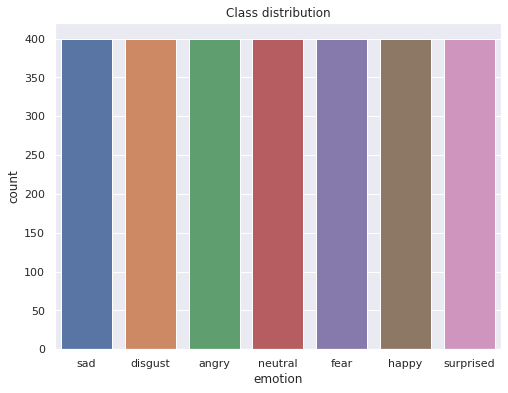

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
print(df['emotion'].unique())
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8,6))
sns.countplot(x = 'emotion', data = df)
plt.title('Class distribution')
plt.savefig(imgsPath + 'class_distribution.png')
plt.show()

## waveform

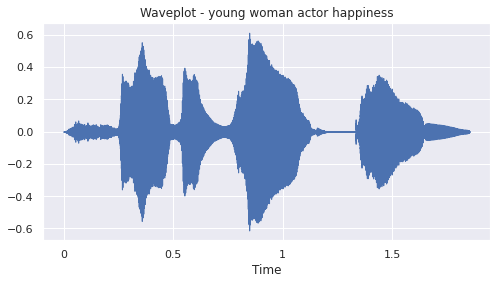

In [3]:
import librosa.display

# waveplot
wavf, sr = librosa.load('../data/tess/yaf/YAF_gun_happy.wav')

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - young woman actor happiness')
plt.savefig(imgsPath + 'waveplot_yaf_happiness.png')
plt.show()

## log-mel spectrogram

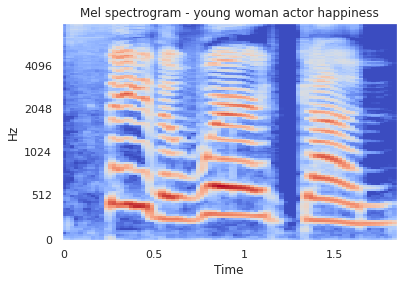

In [4]:
# log-mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=wavf, sr=sr, n_mels=128, fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel spectrogram - young woman actor happiness')
plt.savefig(imgsPath + 'mel_spec_yaf_happiness.png')
plt.show()

# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [5]:
import librosa

# log-mel spectrogram into mfcc

logMelSpecVal = []

def parse_audio_file(pathToFile, _duration, sampleRate):
    # load file
    wavf, sample_rate = librosa.load(pathToFile, res_type="kaiser_fast", duration=_duration, sr=sampleRate)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 2, 44100)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,emotion,0,1,2,3,4,5,6,7,8,...,163,164,165,166,167,168,169,170,171,172
0,sad,-44.866684,-42.563484,-42.934090,-42.198429,-38.585060,-37.314648,-39.344276,-39.559017,-38.614834,...,-41.979794,-38.103256,-35.165031,-30.712734,-25.250000,-21.929203,-19.830929,-19.868361,-22.233919,-21.251535
1,disgust,-41.202820,-38.517208,-37.521523,-35.928848,-36.701500,-37.414253,-36.393902,-33.882385,-32.767769,...,-20.967327,-22.963118,-22.885572,-22.221870,-23.507053,-24.068279,-25.479784,-24.551914,-20.904539,-16.470636
2,sad,-44.523106,-41.317688,-38.223133,-37.148476,-35.793209,-36.431770,-35.850277,-36.279404,-36.554703,...,-37.707291,-39.314594,-38.339470,-38.279835,-38.296024,-39.444401,-39.700020,-40.861137,-39.896214,-38.872395
3,angry,-41.129044,-41.145790,-40.203060,-40.004387,-39.338234,-38.796188,-36.842579,-37.031277,-36.232571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,neutral,-43.564331,-43.538578,-43.997803,-43.378044,-42.618168,-40.774433,-39.563217,-39.384590,-41.079617,...,-26.839230,-26.929281,-27.145792,-26.891811,-26.995079,-26.535362,-26.693199,-27.490786,-23.562895,-18.484276


# Data split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def data_split(df):
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    # stratified train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

print(X_train.head())
print(y_train.head())

            0          1          2          3          4          5    \
1957 -36.305271 -36.789738 -36.425220 -34.747608 -35.367222 -36.745964   
1105 -40.173527 -41.522141 -42.365028 -39.217091 -35.474632 -35.014355   
254  -43.793388 -43.241306 -43.019321 -41.574070 -40.106453 -35.029846   
2592 -32.160595 -29.258410 -23.278524 -22.255568 -26.362617 -29.601513   
1179 -31.665293 -35.141491 -42.677780 -44.319191 -46.104473 -45.569675   

            6          7          8          9    ...        163        164  \
1957 -36.117542 -36.514889 -36.810520 -36.554073  ... -36.101200 -39.634762   
1105 -34.125809 -33.744308 -32.054882 -32.173038  ...   0.000000   0.000000   
254  -33.976143 -34.539223 -33.108162 -34.407253  ... -46.415386 -39.463905   
2592 -29.792355 -33.346142 -32.624657 -30.397259  ... -27.827576 -29.221291   
1179 -42.089725 -39.481453 -39.381378 -37.650951  ... -26.674839 -26.402981   

            165        166        167        168        169        170  \
1957  

# Data preparation and normalization

In [7]:
from keras.utils import to_categorical

def data_preprocessing(X_train, X_test, y_train, y_test):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

    # turn data into arrays for keras
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(y_train.shape)
    print(y_test.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))

    print(y_test[0:3])

    print(lb.classes_)

    # data reshaping
    X_train = X_train[:,:,np.newaxis]
    X_test = X_test[:,:,np.newaxis]

    print(X_train.shape)
    
    return X_train, X_test, y_train, y_test, lb

X_train, X_test, y_train, y_test, lb = data_preprocessing(X_train, X_test, y_train, y_test)

2022-06-08 16:51:14.751123: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(2240,)
(560,)
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprised']
(2240, 173, 1)


# Model architecture

- [model architecture info](https://www.researchgate.net/profile/Gregor-Hofer-3/publication/335829168_Analysis_of_Deep_Learning_Architectures_for_Cross-Corpus_Speech_Emotion_Recognition/links/5e2f0a2f4585152d156d9f4f/Analysis-of-Deep-Learning-Architectures-for-Cross-Corpus-Speech-Emotion-Recognition.pdf)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.utils import plot_model

# model initialization
def get_model(hidden_layers_count = 4, layers_neurons_count = [64, 128, 128, 256], activation_function = 'relu',
             output_activation_function = 'sigmoid', conv_kernel_size = 10, pooling_pool_size = 8,
              loss_function = 'categorical_crossentropy', opt = keras.optimizers.Adam(learning_rate=0.001),
             dropout_rate = 0.4):
    
    model = tf.keras.Sequential()
    
    # input layer
    model.add(layers.Conv1D(layers_neurons_count[0], kernel_size = conv_kernel_size, activation = activation_function,
                           input_shape = (X_train.shape[1], 1)))
    
    # hidden layers
    for i in range(1, hidden_layers_count - 1):
        model.add(layers.Conv1D(layers_neurons_count[i], kernel_size=conv_kernel_size,
                               activation=activation_function))
        model.add(layers.MaxPooling1D(pool_size=pooling_pool_size))
        model.add(layers.Dropout(dropout_rate))
        
    # fully connected layer
    model.add(layers.Flatten())
    model.add(layers.Dense(layers_neurons_count[-1], activation=activation_function))
    model.add(layers.Dropout(dropout_rate))
    
    # output layer
    model.add(layers.Dense(7, activation=output_activation_function))
    
    # loss function and optimizer
    model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])
    
    return model

# Model training and export

In [9]:
from keras.callbacks import ModelCheckpoint

def fit_save_results(model, custom_model_name = 'default_model', paths = [modelsPath, imgsPath],
                    batch_size = 32, epochs = 40):
    
    # new dir prep
    for p in paths:
        os.makedirs(os.path.join(p, custom_model_name), exist_ok=True)
    
    # use checkpoints to save best model
    checkpoint = ModelCheckpoint(os.path.join(paths[0], custom_model_name), monitor='val_accuracy', verbose=0,
                                 save_best_only=True, mode='max')

    # fit model
    model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                              validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=0)

    # plot model accuracy and loss over epochs
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(os.path.join(paths[1], custom_model_name, f'{custom_model_name}_accuracy.png'))
    plt.show()

    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(os.path.join(paths[1], custom_model_name, f'{custom_model_name}_loss.png'))
    plt.show()
    
    # loss and accuracy percentage on test set
    with open(os.path.join(paths[1], custom_model_name, f'{custom_model_name}_res.txt'), 'w') as f:
        f.write(f"Loss of the model is - {model.evaluate(X_test,y_test)[0]}")
        f.write(f"Accuracy of the model is - {model.evaluate(X_test,y_test)[1]*100}%")
    
    return

# Hyperparameter tuning

## Architecture (layers, neurons count)

2022-06-07 19:51:58.379303: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-07 19:51:58.380356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-07 19:51:58.429736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 19:51:58.429852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 3GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 9 deviceMemorySize: 2.95GiB deviceMemoryBandwidth: 178.99GiB/s
2022-06-07 19:51:58.429884: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-07 19:51:58.431060: I tensorflow/stream_executor/platfor

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 164, 1024)         11264     
_________________________________________________________________
flatten (Flatten)            (None, 167936)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               21495936  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 21,508,103
Trainable params: 21,508,103
Non-trainable params: 0
_________________________________________________________________


2022-06-07 19:51:59.030081: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-07 19:51:59.121243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7



Epoch 00001: val_accuracy improved from -inf to 0.89286, saving model to ../models/tess_hp_opt/[1024,_128]_model


2022-06-07 19:52:01.049274: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[1024,_128]_model/assets

Epoch 00002: val_accuracy did not improve from 0.89286

Epoch 00003: val_accuracy improved from 0.89286 to 0.91607, saving model to ../models/tess_hp_opt/[1024,_128]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[1024,_128]_model/assets

Epoch 00004: val_accuracy did not improve from 0.91607

Epoch 00005: val_accuracy did not improve from 0.91607

Epoch 00006: val_accuracy did not improve from 0.91607

Epoch 00007: val_accuracy did not improve from 0.91607

Epoch 00008: val_accuracy improved from 0.91607 to 0.92143, saving model to ../models/tess_hp_opt/[1024,_128]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[1024,_128]_model/assets

Epoch 00009: val_accuracy did not improve from 0.92143

Epoch 00010: val_accuracy did not improve from 0.92143

Epoch 00011: val_accuracy did not improve from 0.92143

Epoch 00012: val_accuracy did not improve from 0.92143

Epoch 00013: va

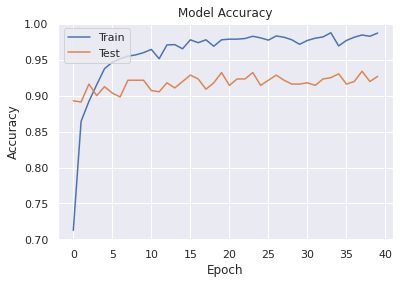

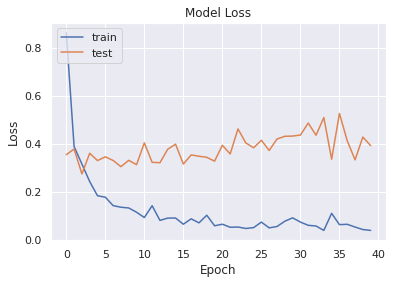

18/18 [==============================] - 0s 6ms/step - loss: 0.3921 - accuracy: 0.9268
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 164, 64)           704       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 155, 512)          328192    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 512)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 512)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9728)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1245312   
_________________________________

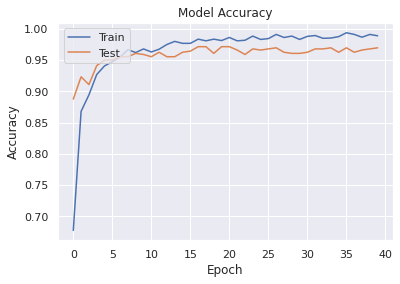

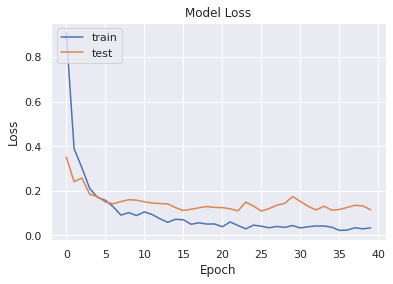

18/18 [==============================] - 0s 3ms/step - loss: 0.1154 - accuracy: 0.9696
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 164, 173)          1903      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 155, 512)          886272    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 512)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 512)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9728)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4981248   
_________________________________

2022-06-07 19:53:22.538699: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-07 19:53:22.598435: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.



Epoch 00001: val_accuracy improved from -inf to 0.85893, saving model to ../models/tess_hp_opt/[173,_512,_512]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[173,_512,_512]_model/assets

Epoch 00002: val_accuracy improved from 0.85893 to 0.91964, saving model to ../models/tess_hp_opt/[173,_512,_512]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[173,_512,_512]_model/assets

Epoch 00003: val_accuracy did not improve from 0.91964

Epoch 00004: val_accuracy did not improve from 0.91964

Epoch 00005: val_accuracy improved from 0.91964 to 0.93214, saving model to ../models/tess_hp_opt/[173,_512,_512]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[173,_512,_512]_model/assets

Epoch 00006: val_accuracy improved from 0.93214 to 0.94107, saving model to ../models/tess_hp_opt/[173,_512,_512]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[173,_512,_512]_model/assets

Epoch 00007: val_accuracy did not improve from 0.94107

Epoch 

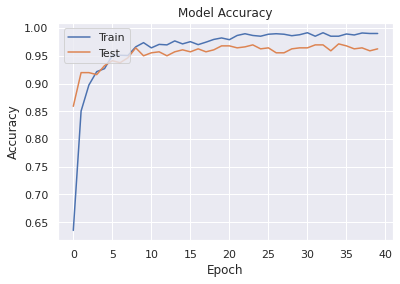

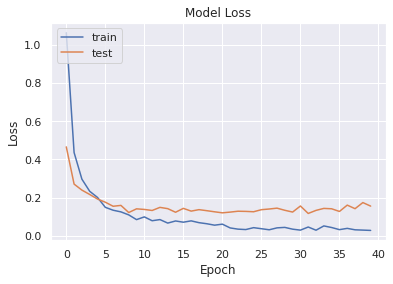

18/18 [==============================] - 0s 4ms/step - loss: 0.1549 - accuracy: 0.9625
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 164, 64)           704       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 155, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 128)           163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
_________________________________

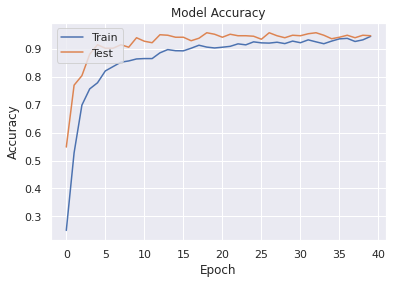

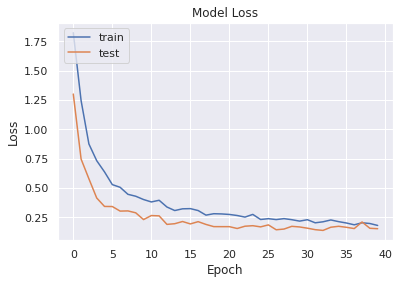

18/18 [==============================] - 0s 2ms/step - loss: 0.1533 - accuracy: 0.9464
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 164, 64)           704       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 155, 64)           41024     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 10, 64)            41024     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1, 64)             0         
_________________________________

2022-06-07 19:54:27.966434: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-07 19:54:27.986342: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-07 19:54:27.990920: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-07 19:54:28.292925: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Alloc


Epoch 00001: val_accuracy improved from -inf to 0.42679, saving model to ../models/tess_hp_opt/[64,_64,_64,_64]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[64,_64,_64,_64]_model/assets

Epoch 00002: val_accuracy improved from 0.42679 to 0.70357, saving model to ../models/tess_hp_opt/[64,_64,_64,_64]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[64,_64,_64,_64]_model/assets

Epoch 00003: val_accuracy improved from 0.70357 to 0.70536, saving model to ../models/tess_hp_opt/[64,_64,_64,_64]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[64,_64,_64,_64]_model/assets

Epoch 00004: val_accuracy improved from 0.70536 to 0.79107, saving model to ../models/tess_hp_opt/[64,_64,_64,_64]_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/[64,_64,_64,_64]_model/assets

Epoch 00005: val_accuracy improved from 0.79107 to 0.81964, saving model to ../models/tess_hp_opt/[64,_64,_64,_64]_model
INFO:tensorflow:Assets written to: ../models/

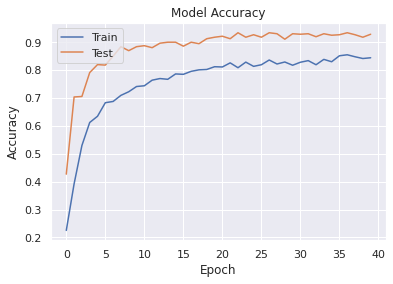

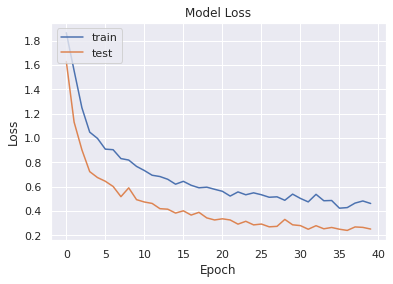

18/18 [==============================] - 0s 2ms/step - loss: 0.2514 - accuracy: 0.9286


In [10]:
best_params = {}

proposed_architectures = (
    [2, [1024, 128]],
    [3, [64, 512, 128]],
    [3, [173, 512, 512]],
    [4, [64, 128, 128, 256]],
    [4, [64, 64, 64, 64]]
)

for arch in proposed_architectures:
    model = get_model(arch[0], arch[1])
    model.summary()
    fit_save_results(model, custom_model_name=f'{str(arch[1]).replace(" ", "_")}_model')


## Activation function


Epoch 00001: val_accuracy improved from -inf to 0.49821, saving model to ../models/tess_hp_opt/act_fun_relu_out_act_fun_sigmoid_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_relu_out_act_fun_sigmoid_model/assets

Epoch 00002: val_accuracy improved from 0.49821 to 0.85000, saving model to ../models/tess_hp_opt/act_fun_relu_out_act_fun_sigmoid_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_relu_out_act_fun_sigmoid_model/assets

Epoch 00003: val_accuracy improved from 0.85000 to 0.85536, saving model to ../models/tess_hp_opt/act_fun_relu_out_act_fun_sigmoid_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_relu_out_act_fun_sigmoid_model/assets

Epoch 00004: val_accuracy improved from 0.85536 to 0.87500, saving model to ../models/tess_hp_opt/act_fun_relu_out_act_fun_sigmoid_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_relu_out_act_fun_sigmoid_model/assets

Epoch 00005: val_accuracy improved fro

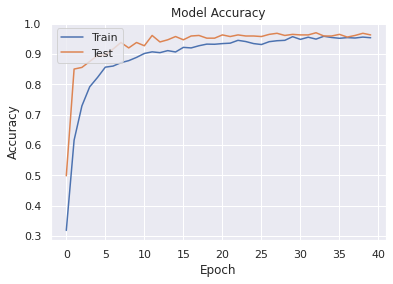

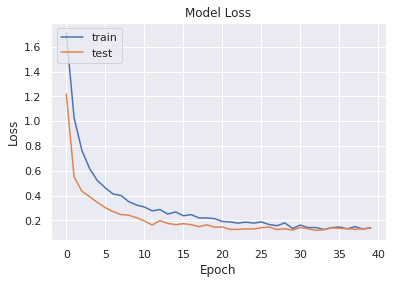

18/18 [==============================] - 0s 2ms/step - loss: 0.1361 - accuracy: 0.9625

Epoch 00001: val_accuracy improved from -inf to 0.73929, saving model to ../models/tess_hp_opt/act_fun_tanh_out_act_fun_softmax_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_tanh_out_act_fun_softmax_model/assets

Epoch 00002: val_accuracy improved from 0.73929 to 0.75000, saving model to ../models/tess_hp_opt/act_fun_tanh_out_act_fun_softmax_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_tanh_out_act_fun_softmax_model/assets

Epoch 00003: val_accuracy improved from 0.75000 to 0.84464, saving model to ../models/tess_hp_opt/act_fun_tanh_out_act_fun_softmax_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_tanh_out_act_fun_softmax_model/assets

Epoch 00004: val_accuracy improved from 0.84464 to 0.88571, saving model to ../models/tess_hp_opt/act_fun_tanh_out_act_fun_softmax_model
INFO:tensorflow:Assets written to: ../models/tess_hp_op

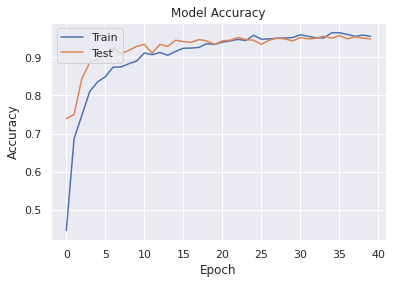

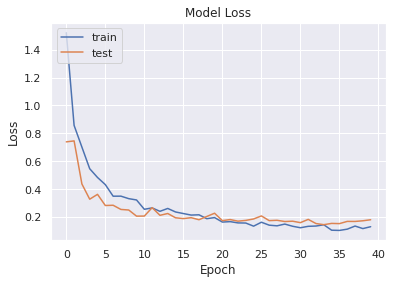

18/18 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9482

Epoch 00001: val_accuracy improved from -inf to 0.54464, saving model to ../models/tess_hp_opt/act_fun_relu_out_act_fun_softmax_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_relu_out_act_fun_softmax_model/assets

Epoch 00002: val_accuracy improved from 0.54464 to 0.83036, saving model to ../models/tess_hp_opt/act_fun_relu_out_act_fun_softmax_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_relu_out_act_fun_softmax_model/assets

Epoch 00003: val_accuracy improved from 0.83036 to 0.89464, saving model to ../models/tess_hp_opt/act_fun_relu_out_act_fun_softmax_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_relu_out_act_fun_softmax_model/assets

Epoch 00004: val_accuracy improved from 0.89464 to 0.91786, saving model to ../models/tess_hp_opt/act_fun_relu_out_act_fun_softmax_model
INFO:tensorflow:Assets written to: ../models/tess_hp_op

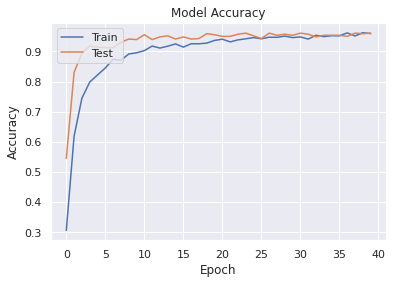

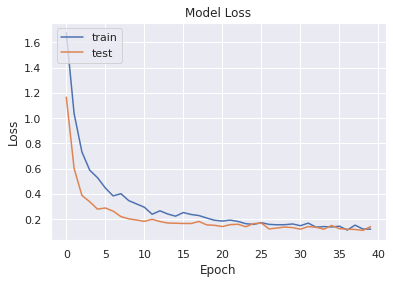

18/18 [==============================] - 0s 2ms/step - loss: 0.1419 - accuracy: 0.9607

Epoch 00001: val_accuracy improved from -inf to 0.73214, saving model to ../models/tess_hp_opt/act_fun_selu_out_act_fun_sigmoid_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_selu_out_act_fun_sigmoid_model/assets

Epoch 00002: val_accuracy improved from 0.73214 to 0.87321, saving model to ../models/tess_hp_opt/act_fun_selu_out_act_fun_sigmoid_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_selu_out_act_fun_sigmoid_model/assets

Epoch 00003: val_accuracy improved from 0.87321 to 0.88571, saving model to ../models/tess_hp_opt/act_fun_selu_out_act_fun_sigmoid_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/act_fun_selu_out_act_fun_sigmoid_model/assets

Epoch 00004: val_accuracy improved from 0.88571 to 0.90714, saving model to ../models/tess_hp_opt/act_fun_selu_out_act_fun_sigmoid_model
INFO:tensorflow:Assets written to: ../models/tess_hp_op

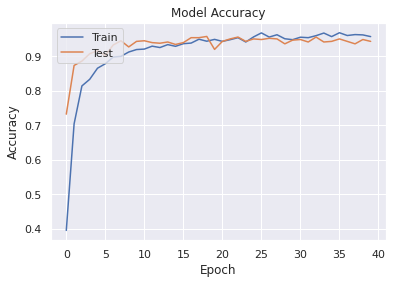

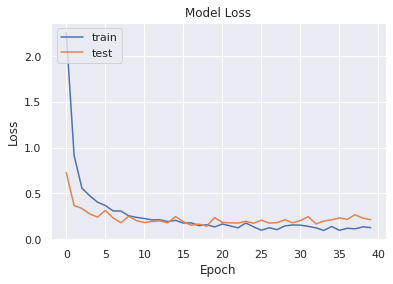

18/18 [==============================] - 0s 2ms/step - loss: 0.2145 - accuracy: 0.9429


In [12]:
# best topology
#best_params['hlayers'] = 2
#best_params['neurons'] = (173, 512, 512)
best_params['hlayers'] = 4
best_params['neurons'] = (64, 128, 128, 256)

activation_functions = (
    {'act_fun': 'relu', 'out_act_fun': 'sigmoid'},
    {'act_fun': 'tanh', 'out_act_fun': 'softmax'},
    {'act_fun': 'relu', 'out_act_fun': 'softmax'},
    {'act_fun': 'selu', 'out_act_fun': 'sigmoid'},
)

for act in activation_functions:
    model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                      activation_function=act['act_fun'],
                      output_activation_function=act['out_act_fun'])
    fit_save_results(model,
                     custom_model_name=f'act_fun_{act["act_fun"]}_out_act_fun_{act["out_act_fun"]}_model')
    

## Conv parameters (kernel size, pool size)

2022-06-07 20:01:33.627227: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-07 20:01:33.631675: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-07 20:01:33.636013: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-07 20:01:34.081504: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Alloc


Epoch 00001: val_accuracy improved from -inf to 0.86786, saving model to ../models/tess_hp_opt/kern_size_3_pool_size_2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_3_pool_size_2_model/assets

Epoch 00002: val_accuracy improved from 0.86786 to 0.88036, saving model to ../models/tess_hp_opt/kern_size_3_pool_size_2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_3_pool_size_2_model/assets

Epoch 00003: val_accuracy improved from 0.88036 to 0.92857, saving model to ../models/tess_hp_opt/kern_size_3_pool_size_2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_3_pool_size_2_model/assets

Epoch 00004: val_accuracy did not improve from 0.92857

Epoch 00005: val_accuracy improved from 0.92857 to 0.93929, saving model to ../models/tess_hp_opt/kern_size_3_pool_size_2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_3_pool_size_2_model/assets

Epoch 00006: val_accuracy did not improve from 0.93929

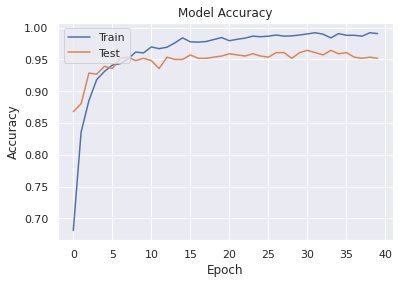

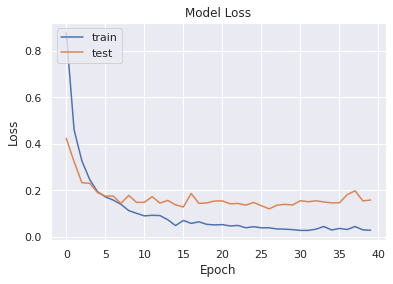

18/18 [==============================] - 0s 2ms/step - loss: 0.1577 - accuracy: 0.9518

Epoch 00001: val_accuracy improved from -inf to 0.83214, saving model to ../models/tess_hp_opt/kern_size_5_pool_size_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_5_pool_size_3_model/assets

Epoch 00002: val_accuracy improved from 0.83214 to 0.91429, saving model to ../models/tess_hp_opt/kern_size_5_pool_size_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_5_pool_size_3_model/assets

Epoch 00003: val_accuracy did not improve from 0.91429

Epoch 00004: val_accuracy improved from 0.91429 to 0.93750, saving model to ../models/tess_hp_opt/kern_size_5_pool_size_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_5_pool_size_3_model/assets

Epoch 00005: val_accuracy did not improve from 0.93750

Epoch 00006: val_accuracy did not improve from 0.93750

Epoch 00007: val_accuracy improved from 0.93750 to 0.94821, saving model to ..

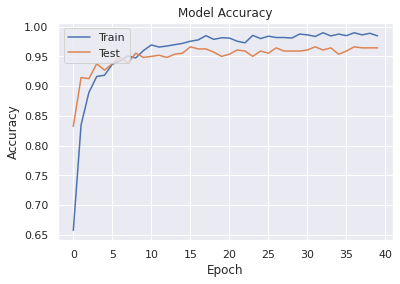

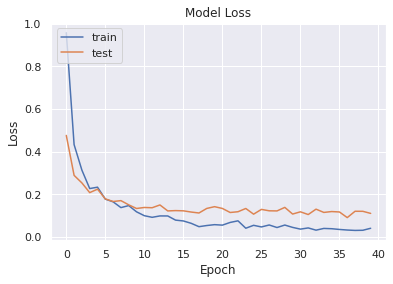

18/18 [==============================] - 0s 2ms/step - loss: 0.1110 - accuracy: 0.9643

Epoch 00001: val_accuracy improved from -inf to 0.84464, saving model to ../models/tess_hp_opt/kern_size_7_pool_size_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_7_pool_size_3_model/assets

Epoch 00002: val_accuracy improved from 0.84464 to 0.88036, saving model to ../models/tess_hp_opt/kern_size_7_pool_size_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_7_pool_size_3_model/assets

Epoch 00003: val_accuracy improved from 0.88036 to 0.92143, saving model to ../models/tess_hp_opt/kern_size_7_pool_size_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_7_pool_size_3_model/assets

Epoch 00004: val_accuracy improved from 0.92143 to 0.92321, saving model to ../models/tess_hp_opt/kern_size_7_pool_size_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_7_pool_size_3_model/assets

Epoch 00005: val_accura

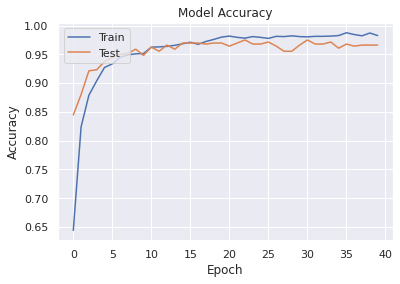

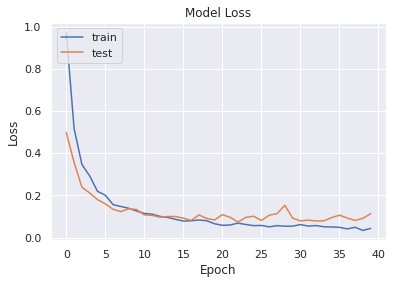

18/18 [==============================] - 0s 2ms/step - loss: 0.1133 - accuracy: 0.9661

Epoch 00001: val_accuracy improved from -inf to 0.85357, saving model to ../models/tess_hp_opt/kern_size_9_pool_size_2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_9_pool_size_2_model/assets

Epoch 00002: val_accuracy improved from 0.85357 to 0.90714, saving model to ../models/tess_hp_opt/kern_size_9_pool_size_2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_9_pool_size_2_model/assets

Epoch 00003: val_accuracy improved from 0.90714 to 0.91786, saving model to ../models/tess_hp_opt/kern_size_9_pool_size_2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_9_pool_size_2_model/assets

Epoch 00004: val_accuracy improved from 0.91786 to 0.92500, saving model to ../models/tess_hp_opt/kern_size_9_pool_size_2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/kern_size_9_pool_size_2_model/assets

Epoch 00005: val_accura

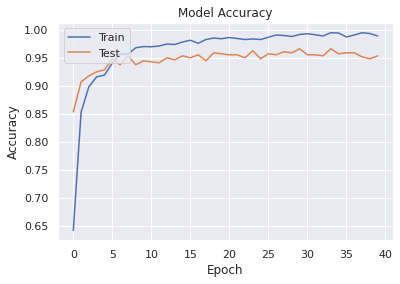

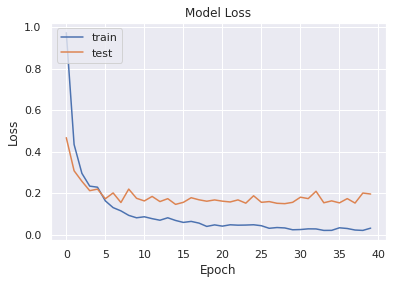

18/18 [==============================] - 0s 2ms/step - loss: 0.1951 - accuracy: 0.9536


In [14]:
# best activation funs
best_params['act_fun'] = 'relu'
best_params['out_act_fun'] = 'softmax'

conv_parameters = (
    {'kern_size': 3, 'pool_size': 2},
    {'kern_size': 5, 'pool_size': 3},
    {'kern_size': 7, 'pool_size': 3},
    {'kern_size': 9, 'pool_size': 2}
)

for params in conv_parameters:
    model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                     activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                     conv_kernel_size=params['kern_size'], pooling_pool_size=params['pool_size'])
    fit_save_results(model,
                     custom_model_name=f'kern_size_{params["kern_size"]}_pool_size_{params["pool_size"]}_model')
    

## Optimizer and learning rate


Epoch 00001: val_accuracy improved from -inf to 0.65357, saving model to ../models/tess_hp_opt/opt_adam_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00002: val_accuracy improved from 0.65357 to 0.77679, saving model to ../models/tess_hp_opt/opt_adam_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00003: val_accuracy improved from 0.77679 to 0.79821, saving model to ../models/tess_hp_opt/opt_adam_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00004: val_accuracy improved from 0.79821 to 0.83214, saving model to ../models/tess_hp_opt/opt_adam_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00005: val_accuracy improved from 0.83214 to 0.84643, saving model to ../models/tess_hp_opt/opt_adam_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00006: val_accuracy improved fr

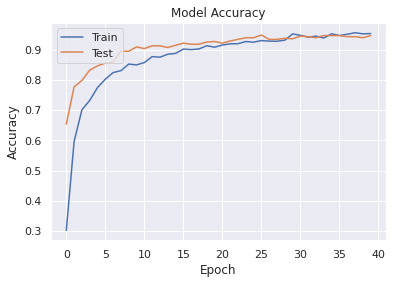

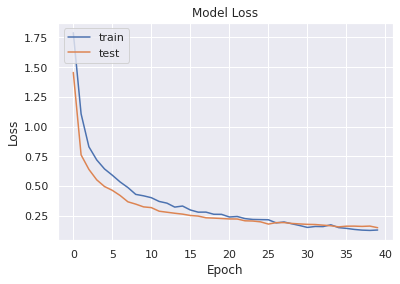

18/18 [==============================] - 0s 2ms/step - loss: 0.1503 - accuracy: 0.9464

Epoch 00001: val_accuracy improved from -inf to 0.57143, saving model to ../models/tess_hp_opt/opt_sgd_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_sgd_model/assets

Epoch 00002: val_accuracy improved from 0.57143 to 0.75714, saving model to ../models/tess_hp_opt/opt_sgd_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_sgd_model/assets

Epoch 00003: val_accuracy did not improve from 0.75714

Epoch 00004: val_accuracy improved from 0.75714 to 0.81607, saving model to ../models/tess_hp_opt/opt_sgd_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_sgd_model/assets

Epoch 00005: val_accuracy improved from 0.81607 to 0.82857, saving model to ../models/tess_hp_opt/opt_sgd_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_sgd_model/assets

Epoch 00006: val_accuracy improved from 0.82857 to 0.85714, saving model to ../models/tess_hp_o

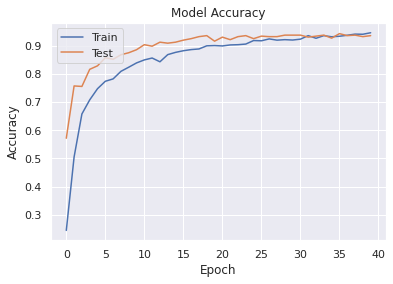

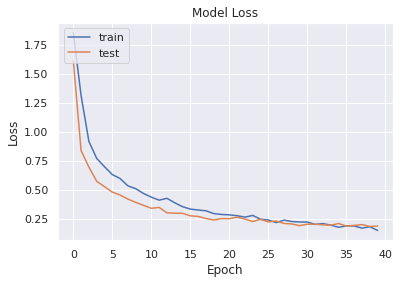

18/18 [==============================] - 0s 2ms/step - loss: 0.1863 - accuracy: 0.9357

Epoch 00001: val_accuracy improved from -inf to 0.66250, saving model to ../models/tess_hp_opt/opt_rmsprop_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_rmsprop_model/assets

Epoch 00002: val_accuracy improved from 0.66250 to 0.75179, saving model to ../models/tess_hp_opt/opt_rmsprop_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_rmsprop_model/assets

Epoch 00003: val_accuracy improved from 0.75179 to 0.78929, saving model to ../models/tess_hp_opt/opt_rmsprop_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_rmsprop_model/assets

Epoch 00004: val_accuracy improved from 0.78929 to 0.81250, saving model to ../models/tess_hp_opt/opt_rmsprop_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_rmsprop_model/assets

Epoch 00005: val_accuracy improved from 0.81250 to 0.84107, saving model to ../models/tess_hp_opt/opt_rmsprop_model
INF

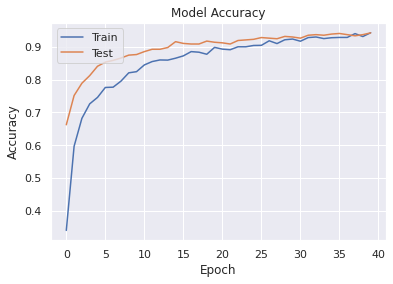

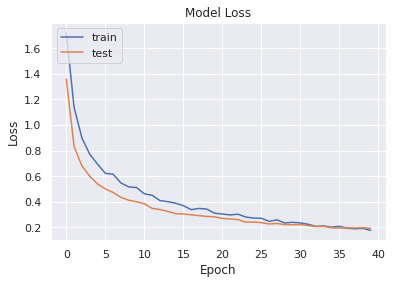

18/18 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9429

Epoch 00001: val_accuracy improved from -inf to 0.73929, saving model to ../models/tess_hp_opt/opt_adagrad_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adagrad_model/assets

Epoch 00002: val_accuracy improved from 0.73929 to 0.82143, saving model to ../models/tess_hp_opt/opt_adagrad_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adagrad_model/assets

Epoch 00003: val_accuracy improved from 0.82143 to 0.84464, saving model to ../models/tess_hp_opt/opt_adagrad_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adagrad_model/assets

Epoch 00004: val_accuracy improved from 0.84464 to 0.86607, saving model to ../models/tess_hp_opt/opt_adagrad_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adagrad_model/assets

Epoch 00005: val_accuracy improved from 0.86607 to 0.87679, saving model to ../models/tess_hp_opt/opt_adagrad_model
INF

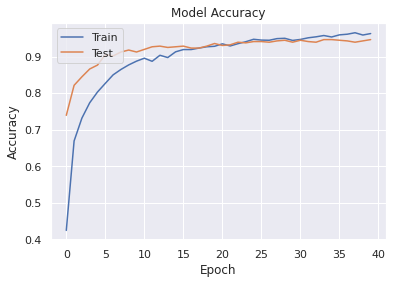

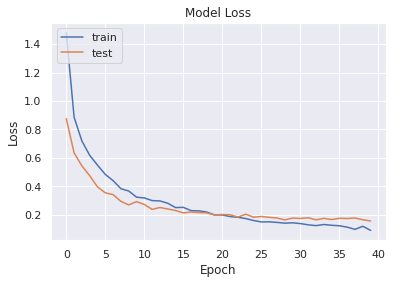

18/18 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 0.9464


In [19]:
# best conv params
best_params['kern_size'] = 7
best_params['pool_size'] = 3

optimizer_loss_params = (
    {'opt_name': 'adam', 'opt': keras.optimizers.Adam(learning_rate=0.0001)},
    {'opt_name': 'sgd', 'opt': keras.optimizers.SGD(learning_rate=0.02)},
    {'opt_name': 'rmsprop', 'opt': keras.optimizers.RMSprop(learning_rate=0.00009)},
    {'opt_name': 'adagrad', 'opt': keras.optimizers.Adagrad(learning_rate=0.013)}
)

for params in optimizer_loss_params:
    model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                     activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                     conv_kernel_size=best_params['kern_size'], pooling_pool_size=best_params['pool_size'],
                     opt=params['opt'])
    fit_save_results(model,
                     custom_model_name=f'opt_{params["opt_name"]}_model')
    

## Batch size and number of epochs


Epoch 00001: val_accuracy improved from -inf to 0.65179, saving model to ../models/tess_hp_opt/batch_size_32_epochs_40_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_32_epochs_40_model/assets

Epoch 00002: val_accuracy improved from 0.65179 to 0.76429, saving model to ../models/tess_hp_opt/batch_size_32_epochs_40_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_32_epochs_40_model/assets

Epoch 00003: val_accuracy improved from 0.76429 to 0.79821, saving model to ../models/tess_hp_opt/batch_size_32_epochs_40_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_32_epochs_40_model/assets

Epoch 00004: val_accuracy improved from 0.79821 to 0.82143, saving model to ../models/tess_hp_opt/batch_size_32_epochs_40_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_32_epochs_40_model/assets

Epoch 00005: val_accuracy improved from 0.82143 to 0.83571, saving model to ../models/tess_hp_opt/batch_size_3

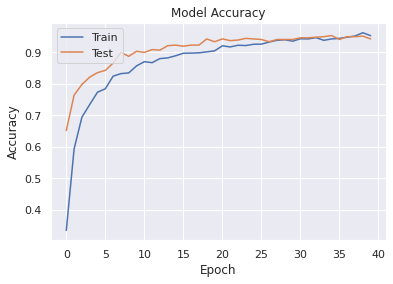

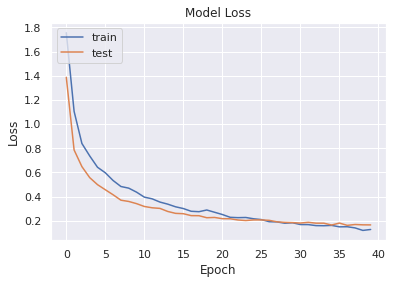

18/18 [==============================] - 0s 2ms/step - loss: 0.1653 - accuracy: 0.9429

Epoch 00001: val_accuracy improved from -inf to 0.76786, saving model to ../models/tess_hp_opt/batch_size_64_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_64_epochs_80_model/assets

Epoch 00002: val_accuracy improved from 0.76786 to 0.82500, saving model to ../models/tess_hp_opt/batch_size_64_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_64_epochs_80_model/assets

Epoch 00003: val_accuracy improved from 0.82500 to 0.86786, saving model to ../models/tess_hp_opt/batch_size_64_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_64_epochs_80_model/assets

Epoch 00004: val_accuracy improved from 0.86786 to 0.89107, saving model to ../models/tess_hp_opt/batch_size_64_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_64_epochs_80_model/assets

Epoch 00005: val_accura

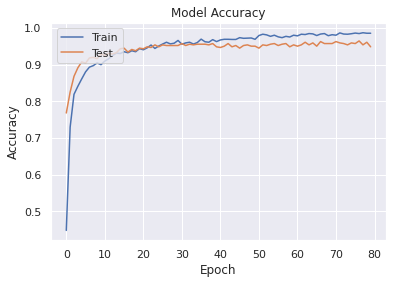

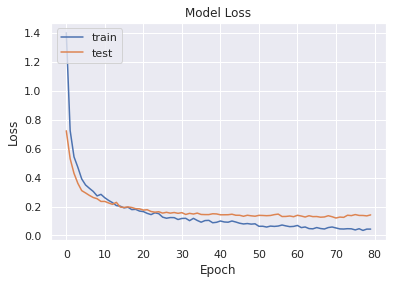

18/18 [==============================] - 0s 2ms/step - loss: 0.1421 - accuracy: 0.9482

Epoch 00001: val_accuracy improved from -inf to 0.84821, saving model to ../models/tess_hp_opt/batch_size_1_epochs_20_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_1_epochs_20_model/assets

Epoch 00002: val_accuracy improved from 0.84821 to 0.91071, saving model to ../models/tess_hp_opt/batch_size_1_epochs_20_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_1_epochs_20_model/assets

Epoch 00003: val_accuracy improved from 0.91071 to 0.91429, saving model to ../models/tess_hp_opt/batch_size_1_epochs_20_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_1_epochs_20_model/assets

Epoch 00004: val_accuracy improved from 0.91429 to 0.92857, saving model to ../models/tess_hp_opt/batch_size_1_epochs_20_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_1_epochs_20_model/assets

Epoch 00005: val_accuracy did n

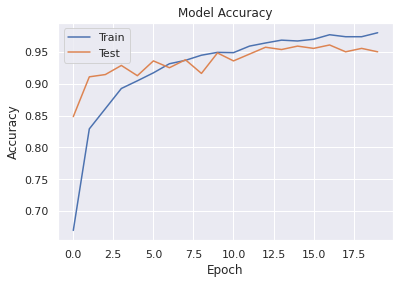

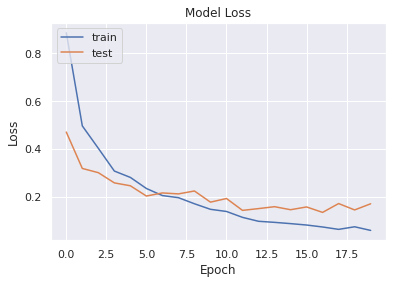

18/18 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.9500


In [21]:
# best optimizer, learning rate params
best_params['opt'] = keras.optimizers.Adam(learning_rate=0.0001)

optimizer_loss_params = (
    {'batch_size': 32, 'epochs': 40},
    {'batch_size': 64, 'epochs': 80},
    {'batch_size': 128, 'epochs': 60},
    {'batch_size': 1, 'epochs': 20}
)

for params in optimizer_loss_params:
    model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                     activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                     conv_kernel_size=best_params['kern_size'], pooling_pool_size=best_params['pool_size'],
                     opt=best_params['opt'])
    fit_save_results(model, batch_size=params['batch_size'], epochs=params['epochs'],
                    custom_model_name=f'batch_size_{params["batch_size"]}_epochs_{params["epochs"]}_model')
    

## Dropout rate

INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_o

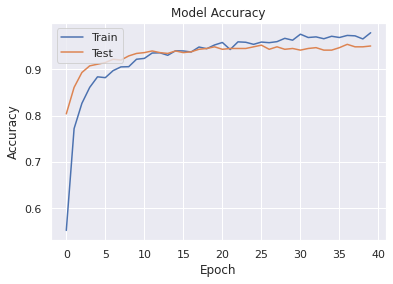

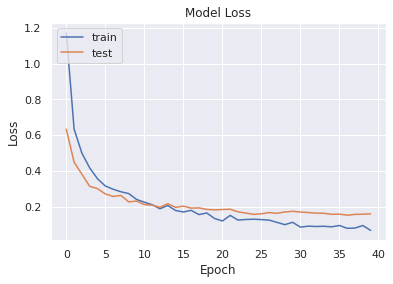

18/18 [==============================] - 0s 2ms/step - loss: 0.1590 - accuracy: 0.9500
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets


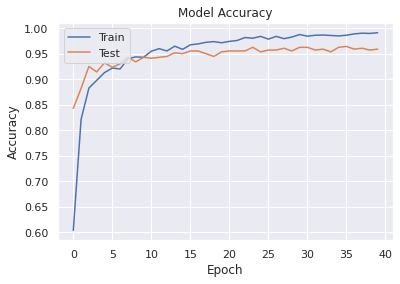

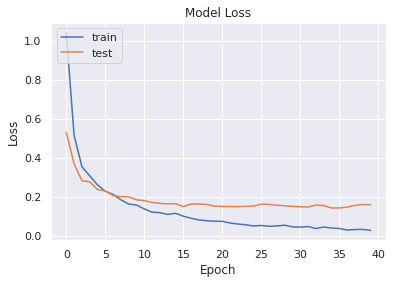

18/18 [==============================] - 0s 2ms/step - loss: 0.1603 - accuracy: 0.9589
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_

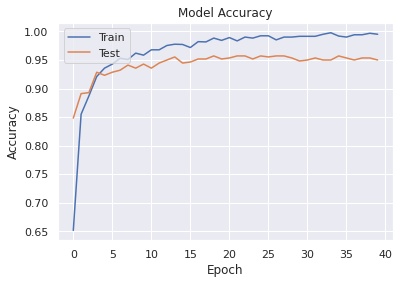

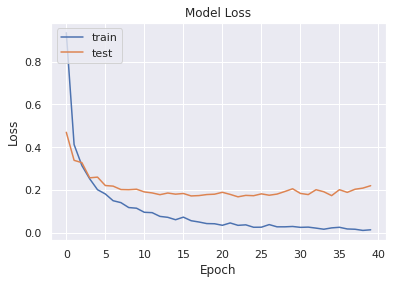

18/18 [==============================] - 0s 2ms/step - loss: 0.2202 - accuracy: 0.9500
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_

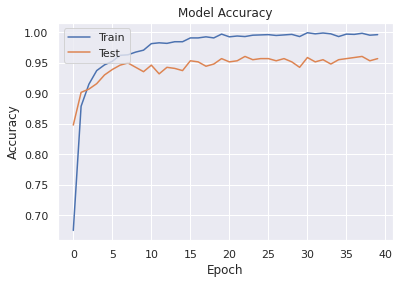

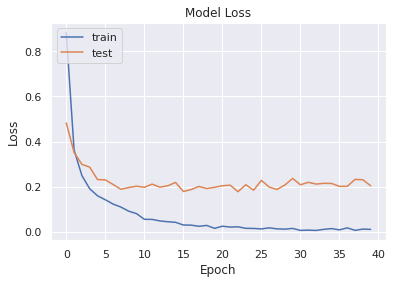

18/18 [==============================] - 0s 2ms/step - loss: 0.2047 - accuracy: 0.9571


In [23]:
# best batch size and epochs
best_params['batch_size'] = 32
best_params['epochs'] = 40

dropout_rate_params = (
    0.4,
    0.3,
    0.2,
    0.1
)

for param in dropout_rate_params:
    model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                     activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                     conv_kernel_size=best_params['kern_size'], pooling_pool_size=best_params['pool_size'],
                     opt=best_params['opt'], dropout_rate=param)
    fit_save_results(model, batch_size=best_params['batch_size'], epochs=best_params['epochs'],
                    custom_model_name=f'droput_rate_{param}_model')

best_params['dropout_rate'] = 0.4

# Results

INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets
INFO:tensorf

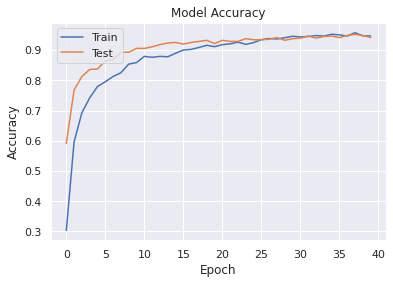

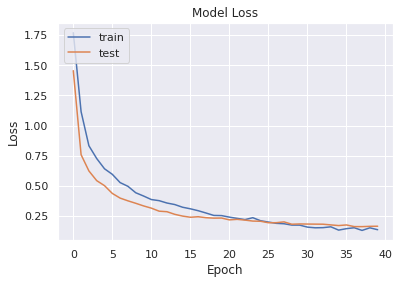

18/18 [==============================] - 0s 2ms/step - loss: 0.1657 - accuracy: 0.9411


In [16]:
best_params = {}
best_params['hlayers'] = 4
best_params['neurons'] = (64, 128, 128, 256)
best_params['act_fun'] = 'relu'
best_params['out_act_fun'] = 'softmax'
best_params['kern_size'] = 7
best_params['pool_size'] = 3
best_params['opt'] = keras.optimizers.Adam(learning_rate=0.0001)
best_params['batch_size'] = 32
best_params['epochs'] = 40
best_params['dropout_rate'] = 0.4

model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                 activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                 conv_kernel_size=best_params['kern_size'], pooling_pool_size=best_params['pool_size'],
                 opt=best_params['opt'], dropout_rate=best_params['dropout_rate'])
fit_save_results(model, batch_size=best_params['batch_size'], epochs=best_params['epochs'],
                custom_model_name=f'final_model')

## accuracy and loss

In [17]:
# loss and accuracy percentage on test set
print("Loss of the model is - ", model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - ", model.evaluate(X_test,y_test)[1]*100, "%")

18/18 [==============================] - 0s 2ms/step - loss: 0.1657 - accuracy: 0.9411
Loss of the model is -  0.16570676863193512
18/18 [==============================] - 0s 2ms/step - loss: 0.1657 - accuracy: 0.9411
Accuracy of the model is -  94.10714507102966 %


In [18]:
# predictions
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,happy,happy
2,neutral,neutral
3,surprised,surprised
4,happy,happy
5,sad,sad
6,sad,sad
7,fear,fear
8,surprised,surprised
9,surprised,surprised


## confusion matrix

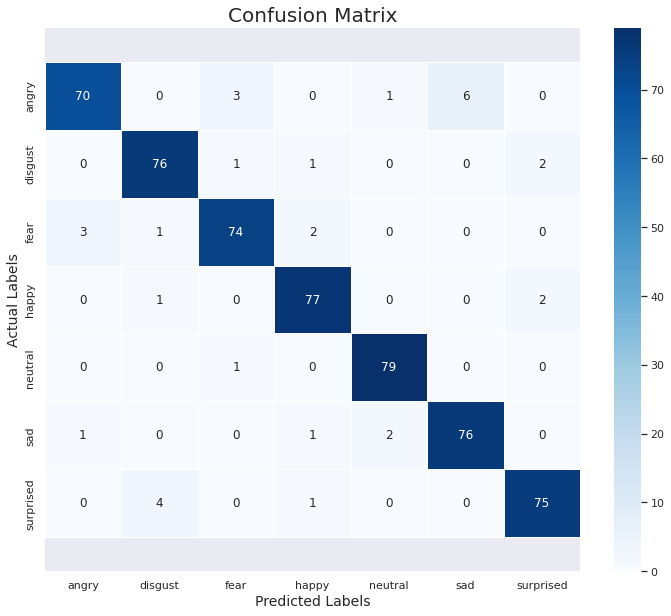

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_], columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgsPath + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [20]:
print(classification_report(actual, predictions, target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']))

              precision    recall  f1-score   support

       angry       0.95      0.88      0.91        80
     disgust       0.93      0.95      0.94        80
        fear       0.94      0.93      0.93        80
       happy       0.94      0.96      0.95        80
     neutral       0.96      0.99      0.98        80
         sad       0.93      0.95      0.94        80
   surprised       0.95      0.94      0.94        80

    accuracy                           0.94       560
   macro avg       0.94      0.94      0.94       560
weighted avg       0.94      0.94      0.94       560

